<a href="https://colab.research.google.com/github/jlc248/satellite-resources/blob/main/docs/source/MTG_Lightning_Imager_gridded_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MTG Lightning Imager gridded data

Lightning is a frequent hazard for most locations of the world. Its detection and observation is important for public safety and meteorological research.

According to [EUMETSAT](https://www.eumetsat.int/ISS-LIS-data-analysis), *“Lightning is a source of different types of signals in the electromagnetic spectrum. In detail: Very High Frequency signals (VHF), Very Low Frequency signals (VLF), Low Frequency signals (LF), and finally optical pulses. These signals can be detected by different type of instruments and can be employed for the location in space and time of lightning, as well as for their physical characterisation. Different instruments are capable of detecting either a part of or all the lightning categories listed above.”*

The Meteosat Third Generation (MTG) Lightning Imager (LI) detects the optical pulses of lightning. One advantage of spaceborne lightning imagers is that they often have a more uniform field of view and (to some extent) detection efficiency over much of that field of view. However, they cannot directly discern in-cloud lightning vs. cloud-to-ground lightning like many ground-based networks are able to.

This notebook will cover the basics of working with some gridded LI data.

## Background

Flashes must be clustered from LI events and groups. LI events are pixels in the LI optical cameras (OC) that are illuminated above the background reference illumination and pass other quality controls. Each LI group is a collection of connected events on the same acquisition frame. There are several ways to cluster groups into flashes, but most of the time, two groups are considered part of the same flash when they are ≤ 16.5 km from each other in space and ≤ 330 ms from each other in time. See the [MTG LI level 2 guide](https://user.eumetsat.int/resources/user-guides/mtg-li-level-2-data-guide) for more details.

## Install libraries

In [2]:
!pip install satpy xarray h5py pandas matplotlib eumdac requests cartopy netCDF4 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.0/345.0 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Set up `eumdac` keys

You need a EUMETSAT account and associated keys to run grab data. After [creating an account](https://eoportal.eumetsat.int/cas/login), you can find your "consumer key" and "consumer secret" here: `https://api.eumetsat.int/api-key/`. Copy them and paste them into the code below.

In [3]:
# Import EUMDAC and dependent libraries to begin
import eumdac
import datetime
import shutil
import requests

# Insert your personal key and secret into the single quotes
consumer_key = '65G_tx1T9VJTGlhfyReogvCEhAYa' #'<your-consumer-key>'
consumer_secret = 'gqshysjE6b7thsy1rXOUE4_WT6ca' #'<your-consumer-secret>'

credentials = (consumer_key, consumer_secret)

token = eumdac.AccessToken(credentials)

print(f"This token '{token}' expires {token.expiration}")

This token 'df6af5b1-90f1-3459-96c5-2ddd3f202e1b' expires 2024-11-13 13:56:07.338286


## Download data

Gridded LI data comes in 3 types — "accumulated flashes", "accumulated flash area", and "accumulated flash radiance". See [here](https://resources.eumetrain.org/data/3/362/362.pdf) for more information.

We're going to work with "accumulated flash area", which shows the number of unique flashes contributing to each pixel. I believe this is very analagous to GLM's flash-extent density. To download the flash data into directory `grid_data`, run the following code. We will only download a couple times here.

In [63]:
datastore = eumdac.DataStore(token)

import os
import zipfile
from io import BytesIO
from concurrent.futures import ThreadPoolExecutor, as_completed

# Assume datastore is already defined and connected
searchs = datastore.opensearch("""pi=EO:EUM:DAT:0687&dtstart=2024-11-12T12:41:00&dtend=2024-11-12T12:45:00""")

# Define output directory
outdir = "grid_data"

# Create the data directory if it doesn't exist
os.makedirs(outdir, exist_ok=True)

def download_and_extract(product, outdir):
    try:
        # Create a temporary BytesIO object to hold the downloaded zip file
        with product.open() as fsrc:
            with BytesIO(fsrc.read()) as bio:
                with zipfile.ZipFile(bio, 'r') as zip_ref:
                    # Check if all the files to be extracted already exist
                    all_files_exist = all(os.path.exists(os.path.join(outdir, name)) for name in zip_ref.namelist())
                    if all_files_exist:
                        print(f"All files already exist, skipping download for product: {product}")
                        return
                    # Extract all the contents into the data directory
                    zip_ref.extractall(outdir)
                    print(f'Extracted product finished.')
    except Exception as e:
        print(f"Failed to process product: {e}")

# Use ThreadPoolExecutor to handle concurrency
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = {executor.submit(download_and_extract, product, outdir): product for product in searchs}
    for future in as_completed(futures):
        product = futures[future]
        try:
            future.result()
        except Exception as e:
            print(f"Exception occurred while processing product: {e}")

print("All products processed.")

All files already exist, skipping download for product: W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AFA--FD--x-x--ARC-x_C_EUMT_20241112125034_L2PF_OPE_20241112124000_20241112125000_N__O_0077_0000
All products processed.


In [5]:
!ls grid_data

EOPMetadata.xml
manifest.xml
quicklooks
W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AFA--FD--CHK-BODY--ARC-NC4E_C_EUMT_20241112125019_L2PF_OPE_20241112124000_20241112125000_N__O_0077_0001.nc
W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AFA--FD--CHK-TRAIL--ARC-NC4E_C_EUMT_20241112125034_L2PF_OPE_20241112124000_20241112125000_N__O_0077_0002.nc
W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-AFA--FD--QCK-IMAGE--ARC-PNG_C_EUMT_20241112125019_L2PF_OPE_20241112124000_20241112125000_N__O_0077_0001.jpg


## Visualize the Data

Here, we use the `netCDF4` to load the LI data.

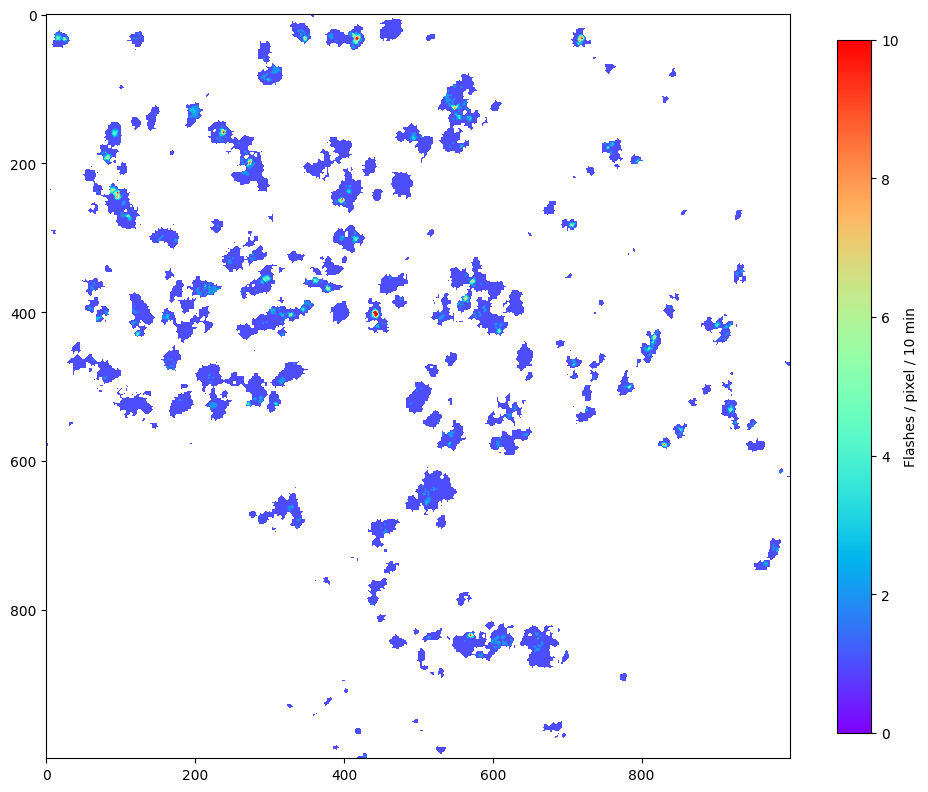

In [6]:
from glob import glob
import os
from numba import jit
import matplotlib.pyplot as plt
import numpy as np
import netCDF4

@jit(nopython=True)
def fill_li_grid(accums, I, J):
    """
    This function will un-sparse the LI sparse grids.
    The 2-km dimensions are hard-coded (5568,5568).
    """

    grid = np.zeros((5568,5568), dtype=np.float32)

    for ind in range(len(I)):
        grid[I[ind], J[ind]] = accums[ind]

    return grid



nc = netCDF4.Dataset(glob("grid_data/*BODY*OPE_20241112124000*.nc")[0], "r")
# The flash counts...not sure why it's called "accumulated_flash_area"
sparse_accum = nc.variables["accumulated_flash_area"][:]
# 'Projection' coordinates
x = nc.variables['x'][:]
y = nc.variables['y'][:]
# Unscaling the projection coordinates to get the row (I) and column (J) indices
J = np.round((x - nc.variables['x'].add_offset) / nc.variables['x'].scale_factor).astype(int)
I = np.round((y - nc.variables['y'].add_offset) / nc.variables['y'].scale_factor).astype(int)
nc.close()

# Performing the unsparsing. Because we use jit to speed it up, we have to use
# numpy.ndarray instead of a masked array.
accum = np.flipud(fill_li_grid(sparse_accum.filled(0), I.filled(0), J.filled(0)))

# Now make the figure
fig = plt.figure(figsize=(12,12))
# Masking missing data and zooming in so we can see some detail.
plt.imshow(np.ma.masked_less_equal(accum[3000:4000,3500:4500], 0), vmin=0, vmax=10, cmap='rainbow')
plt.colorbar(orientation="vertical", label='Flashes / pixel / 10 min', shrink=0.75)
plt.show()

### Creating a geolocated image

The above is fine, but we really want a geolocated image, along with some context about the clouds.

Let's download some FCI data and use `netCDF4` to load it. This may take some time (~10 minutes), as full-disk FCI time stamps are comprised of 41 files and contain all 16 FCI channels.

#### Download FCI data

In [8]:
# Assume datastore is already defined and connected
searchs = datastore.opensearch("""pi=EO:EUM:DAT:0662&dtstart=2024-11-12T12:41:00&dtend=2024-11-12T12:42:00""")

outdir = "fci_data"
# Create the data directory if it doesn't exist
os.makedirs(outdir, exist_ok=True)

# Use ThreadPoolExecutor to handle concurrency
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = {executor.submit(download_and_extract, product, outdir): product for product in searchs}
    for future in as_completed(futures):
        product = futures[future]
        try:
            future.result()
        except Exception as e:
            print(f"Exception occurred while processing product: {e}")

print("All products processed.")

Extracted product finished.
All files already exist, skipping download for product: W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--x-x---x_C_EUMT_20241112124259_IDPFI_OPE_20241112124007_20241112124924_N__C_0077_0000
All products processed.


#### Read and load the IR data

Usually I use `satpy` to read FCI data, but Colab was crashing when I tried to extract a `numpy` array (even a cropped one), so now I'm simply reading the data chunk-by-chunk and concatenating it together. We only need the `x` coordinates on the first chunk, because they are the same for each chunk. For some reason unknown to me, the `x` coordinates need to be flipped. It makes sense why `y` would be flipped, but not `x`.


In [57]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import satpy
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import netCDF4

# Read the data with netCDF4

datafiles = np.sort(glob('fci_data/*BODY*nc'))

for ii in range(len(datafiles)):
    # Get the correct file/chunk of the FD
    file_name = [element for element in datafiles if f"{str(ii+1).zfill(4)}.nc" in element]
    nc = netCDF4.Dataset(file_name[0], 'r')
    data_chunk = nc.groups['data']['ir_105']['measured'].variables['effective_radiance'][:]
    y_chunk = nc.groups['data']['ir_105']['measured'].variables['y'][:]
    if ii == 0:
        # We only x on the fi
        x = nc.groups['data']['ir_105']['measured'].variables['x'][:]
        # grab the imager height and satellite longitude
        sat_height = nc.groups['data'].variables['mtg_geos_projection'].perspective_point_height
        lon_0 = nc.groups['data'].variables['mtg_geos_projection'].longitude_of_projection_origin
    nc.close()

    if ii == 0:
        ir_data = np.copy(data_chunk)
        y = np.copy(y_chunk)
    else:
        ir_data = np.concatenate([ir_data, data_chunk], axis=0)
        y = np.concatenate([y, y_chunk], axis=0)

print(f"shape={ir_data.shape}")

# Not using satpy b/c the Colab crashes when retrieving the data for some
# unknown reason. Keeping the code here for off-Colab analysis.
# Read the data with satpy #FIXME only for
#orig_scn = satpy.Scene(filenames=datafiles, reader="fci_l1c_nc")

# Using the 10.5 µm brightness temperature
#orig_scn.load(['ir_105'], upper_right_corner="NE")

shape=(5568, 5568)


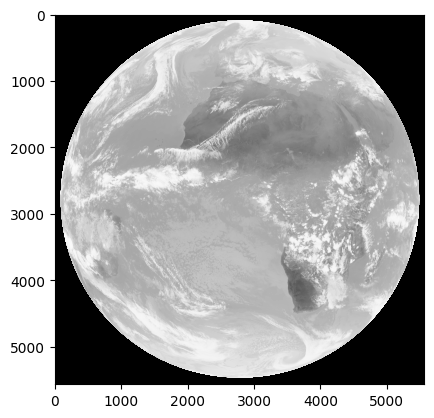

In [58]:
# Check that the data look normal
ir_data = np.flipud(ir_data)
y = y[::-1] # flips y-coordinate
x = x[::-1] # flips x-coordinate. Not sure why x needs to be flipped.
plt.imshow(ir_data, cmap='Greys', vmin=0, vmax=225)
plt.show()

#### Set up the map and plot

/usr/local/lib/python3.10/dist-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


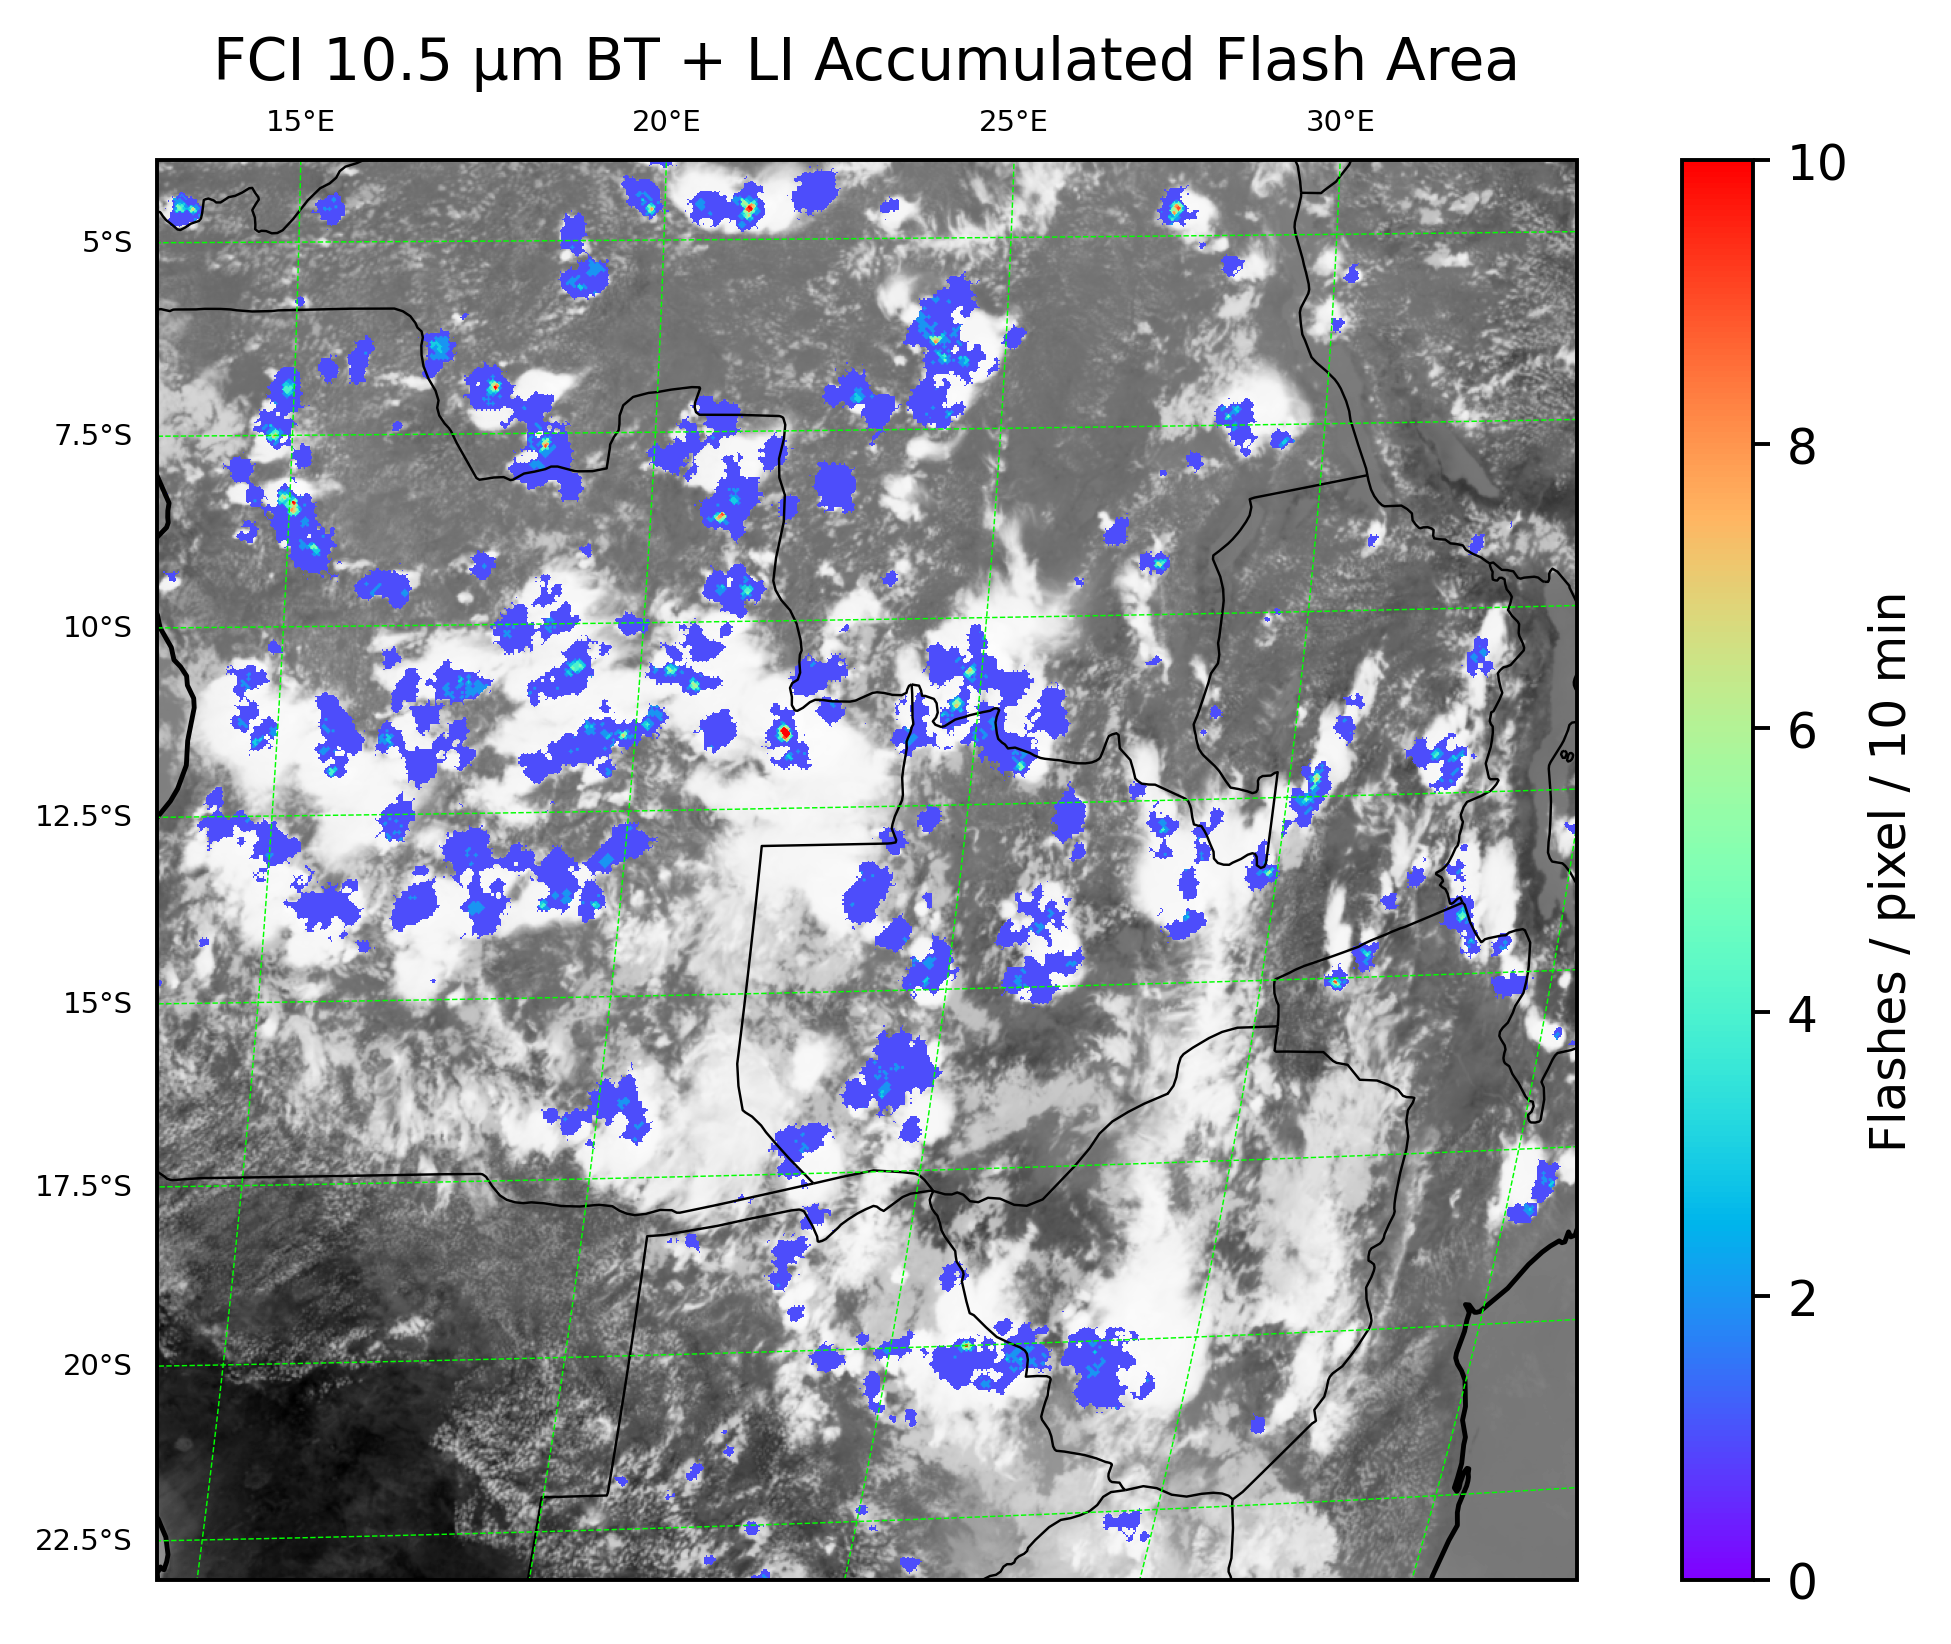

In [61]:
# Define the map projection
#lon_0 = orig_scn["ir_105"].attrs["area"].proj_dict["lon_0"]
crs = ccrs.Geostationary(central_longitude=lon_0)

# Create a new figure with a high DPI for better resolution
plt.figure(dpi=350)
ax = plt.axes(projection=crs, frameon=True)

# Get the x and y projection coords using satpy
#x = orig_scn["ir_105"].x.compute().data
#y = orig_scn["ir_105"].y.compute().data

# transform to projection coordinates
X = x * sat_height
Y = y * sat_height

# Subsect to the region we want
xs = slice(3500,4500)
Xs = X[xs]
ys = slice(3000,4000)
Ys = Y[ys]


# Set the geographic extent of the image in projection coordinates
extent = [Xs.min(), Xs.max(), Ys.min(), Ys.max()]
ax.set_extent(extent, crs=crs)

# Crop the scn to the domain
#scn = orig_scn.crop(xy_bbox=[x.min(), y.min(), x.max(), y.max()])

# Add land and border features to the map
ax.add_feature(cfeature.LAND.with_scale("50m"), facecolor="gray")
ax.add_feature(cfeature.BORDERS.with_scale("50m"), lw=0.5, color="black")
ax.coastlines()

# Plot the IR data -- FIXME: currently crashing the kernel
#ax.imshow(scn['ir_105'].compute().data, cmap="Greys", extent=extent, transform=crs)
ax.imshow(ir_data[ys, xs], cmap="Greys", extent=extent, transform=crs)

# Plot the LI data
ltg = ax.imshow(np.ma.masked_less_equal(accum[ys,xs], 0), vmin=0, vmax=10, cmap='rainbow', extent=extent, transform=crs)

# Lat/Lon gridlines
gl = ax.gridlines(
      crs=ccrs.PlateCarree(),
      draw_labels=['top','left'],
      linewidth=0.3,
      color="#00FF00",
      linestyle="--",
    )
# Customize the gridline labels
gl.xlabel_style = {"size": 6}
gl.ylabel_style = {"size": 6}

# Colorbar
plt.colorbar(ltg, orientation="vertical", label='Flashes / pixel / 10 min')

# Set the title of the plot with the current minute
ax.set_title("FCI 10.5 µm BT + LI Accumulated Flash Area")

# Adjust layout to prevent clipping of elements
plt.tight_layout()

plt.show()

This looks good! Hopefully this notebook will help get you started on your journey with using MTG FCI and LI data.